# December Questions from Dave Turner

__2022/02/01__

Meeting with Dave is 2022/02/01 at 4:30pm.

Notes from our last conversation from my lab notebook:  

"
1. _The CO2 band is telling us about the conditions of the stratosphere. There is a decrease in OLR (cooling) in the fall and January, and increase in OLR (warming) and March and April. Is this consistent with observations of stratospheric temperatures? What is driving these changes?_

2. _There appears to be a decrease in OLR in JJA. Is this from surface temperatures (doubtful), clouds (maybe), water vapor (more likely)? Try the spatio-temporal correlation with the spectral bands just for these months._  

3. _To tease out the effect of clouds on the OLR vs. WV. Pick two water vapor bands with similar optical depth (calculate how) but in different portions of spectrum. Dave suggested 400 +/- 10 cm-1 (FIR) and 6.7um (v2). In a clear-sky scenario, the trends should basically be the same after correcting for planck emission differences because absorption is dominated by WV. In a full-sky scenario, however, the FIR band should have much more FIR scattering than the 6.7um band if clouds are important. A key caveat: this product is derived and would need to have clouds and LW scattering implemented to show this effect. Also if clouds aren’t changing we wouldn’t see it either. This becomes kind of messy._  

"

I will try and go through and investigate each of these questions. Might have to split this notebook into several notebooks so there aren't memory issues and the code remains clear.

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob, copy
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends, MidpointNormalize
    )

import copy
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. CO2 band and stratospheric temperatures

__The CO2 band is telling us about the conditions of the stratosphere. There is a decrease in OLR (cooling) in the fall and January, and increase in OLR (warming) and March and April. Is this consistent with observations of stratospheric temperatures? What is driving these changes?__

I can plot a timeseries of the OLR in the CO2 band and overlay if with stratospheric temperatures (easiest to use the AIRS retrieval even though it is a but duplicative). This is probably the best first easy step.

In [8]:
# Load pre-processed longitudinally averaged AIRS trends
airs_dir = '/glade/work/jonahshaw/obs/AIRS/'
airs_files = glob.glob('%s/proc/**.nc' % airs_dir)
airs_files.sort()

In [3]:
all_data_spec_olr = xr.open_dataset('%s/%s/olr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))
all_data_spec_olr_clr = xr.open_dataset('%s/%s/olr_clr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))

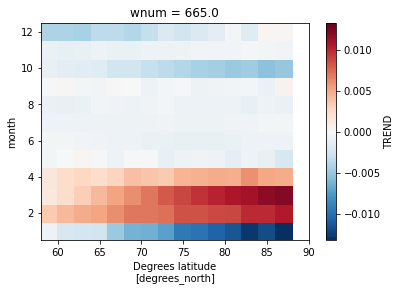

In [7]:
all_data_spec_olr['TREND'].sel(wnum=665).plot()

I need the timeseries, not just the linear trends. Will have to try loading the full dataset.

In [12]:
all_airs = xr.open_mfdataset(airs_files,parallel=True,data_vars=['olr_spectral','olr_clr_spectral']) # only took 30mb! (5gB each actual I think)

In [21]:
# subset data, total memory for each now 440mb
olr_subset = add_weights(all_airs['olr_spectral'].sel(lat=slice(59,None),time=slice('2003-01-01','2018-12-31')).mean(dim='orbit_pass'))
olr_clr_subset = add_weights(all_airs['olr_clr_spectral'].sel(lat=slice(59,None),time=slice('2003-01-01','2018-12-31')).mean(dim='orbit_pass'))

In [23]:
all_airs.close()

In [129]:
olr_subset_CO2 = olr_subset.sel(wnum=slice(645,685))
olr_clr_subset_CO2 = olr_clr_subset.sel(wnum=slice(645,685))

In [130]:
# Compute a masked average for the Arctic (60N-90N)
olr_subset_CO2_mean = masked_average(olr_subset_CO2,weights=olr_subset_CO2['cell_weight'],dim=['lat','lon'])
olr_clr_subset_CO2_mean = masked_average(olr_clr_subset_CO2,weights=olr_subset_CO2['cell_weight'],dim=['lat','lon'])

In [131]:
# Compute delayed dask operations (slow), this shouldn't take so long...there isn't much memory
olr_subset_CO2_mean = olr_subset_CO2_mean.compute()
olr_clr_subset_CO2_mean = olr_clr_subset_CO2_mean.compute()

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


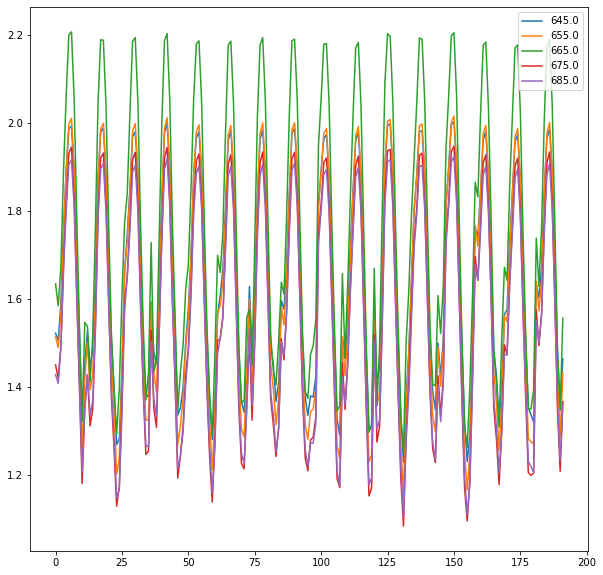

In [132]:
plt.figure(figsize=(10,10))

for wnum in olr_subset_CO2_mean.wnum:
    plt.plot(olr_subset_CO2_mean.sel(wnum=wnum),label=str(wnum.values))
    # print(wnum.values)
    
plt.legend()

All of these wavelength channels basically look the same, so I will sum over them (667 cm-1 is the center of the CO2 band).

In [133]:
olr_subset_CO2_sum = olr_subset_CO2_mean.sum(dim='wnum')
chnl665 = olr_subset_CO2_mean.sel(wnum=665)

def demean(x):
    return (x - x.mean())

detrended_665 = chnl665.groupby('time.month').map(demean)
detrended_allCO2 = olr_subset_CO2_sum.groupby('time.month').map(demean)

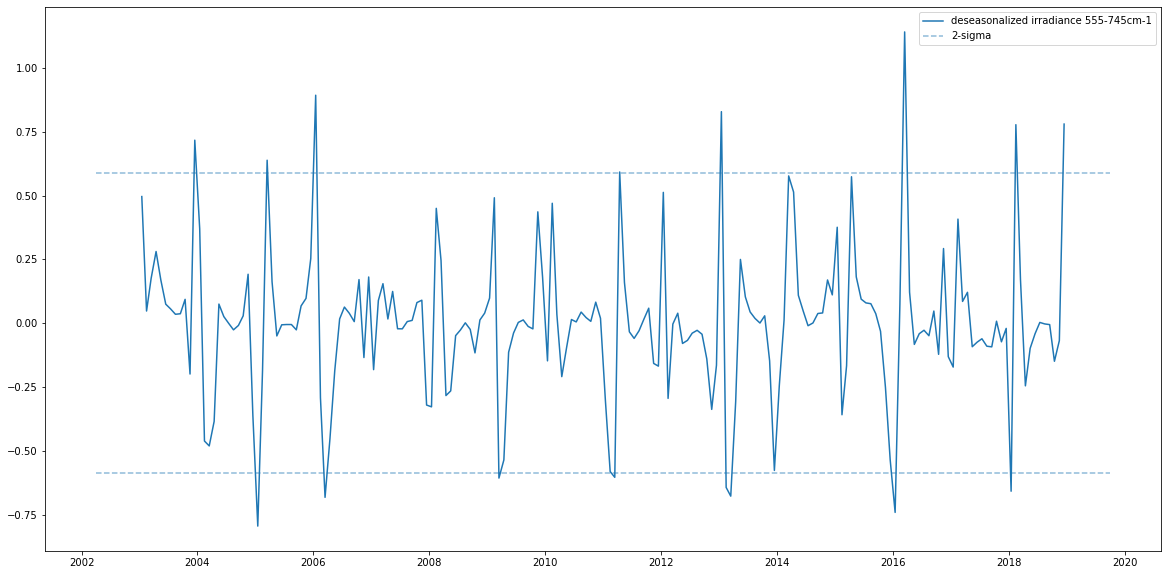

In [136]:
CO2band_std = detrended_allCO2.std()

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,10))

# plt.plot(detrended_665['time'],detrended_665,label='deseasonalized irradiance 665cm-1')
plt.plot(detrended_allCO2['time'],detrended_allCO2,label='deseasonalized irradiance 645-685cm-1')

_xmin,_xmax = ax.get_xlim()
plt.hlines([-2*CO2band_std,2*CO2band_std],xmin=_xmin,xmax=_xmax,alpha=0.5,linestyle='dashed',label='2-sigma')

plt.legend()

More specifically, Dave's question was whether the observed radiation trends in the CO2 band (increase in OLR in April, decrease in January) are correlated to changes in stratospheric temperatures.

## Look at stratospheric temperature records

#### Create function to average over the ascending and descending orbits

In [160]:
# This is incredibly slow...
def average_AIRS_orbits(var,tseries_dir='/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries/'):
    
    ascending_file = glob.glob('%s/*%s_A.*.nc' % (tseries_dir,var))#[0]
    descending_file = glob.glob('%s/*%s_D.*.nc' % (tseries_dir,var))#[0]
                                
    if (len(ascending_file)!=1 or len(descending_file)!=1): # Handle string errors
        print('Unique ascending/descending file not found')
        return ascending_file,descending_file
    
#     print(ascending_file,descending_file)
    
    # Open timeseries files
    ds_A = xr.open_dataset(ascending_file[0])
    ds_D = xr.open_dataset(descending_file[0])
    
    # Rename removing orbit suffix
    ds_A = ds_A.rename({'%s_A' % var:var})
    ds_D = ds_D.rename({'%s_D' % var:var})
    
    # Add orbit dimension for concatenation.
    ds_A = ds_A[var].assign_coords({'orbit':0}).expand_dims('orbit')
    ds_D = ds_D[var].assign_coords({'orbit':1}).expand_dims('orbit')
    
    ds_both = xr.merge([ds_A,ds_D])
    ds_net = ds_both.mean(dim='orbit')[var]
    
    return ds_net
#     return ds_A,ds_

In [161]:
airs_tseries_dir = '/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries/'

In [163]:
airs_temp = average_AIRS_orbits('Temperature') # sooper slow

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [177]:
airs_10mbar_temp_arc = add_weights(airs_temp.sel(StdPressureLev=10,lat=slice(None,60),time=slice('2003-01-01','2018-12-30')))

In [179]:
airs_10mbar_temp_arcmean = masked_average(airs_10mbar_temp_arc,dim=['lat','lon'],weights=airs_10mbar_temp_arc['cell_weight'])

In [182]:
airs_10mbar_temp_arcmean_jan = airs_10mbar_temp_arcmean[airs_10mbar_temp_arcmean['time.month']==1]
airs_10mbar_temp_arcmean_apr = airs_10mbar_temp_arcmean[airs_10mbar_temp_arcmean['time.month']==4]

In [139]:
olr_CO2_jan = olr_subset_CO2_sum[olr_subset_CO2_sum['time.month']==1]
olr_CO2_apr = olr_subset_CO2_sum[olr_subset_CO2_sum['time.month']==4]

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


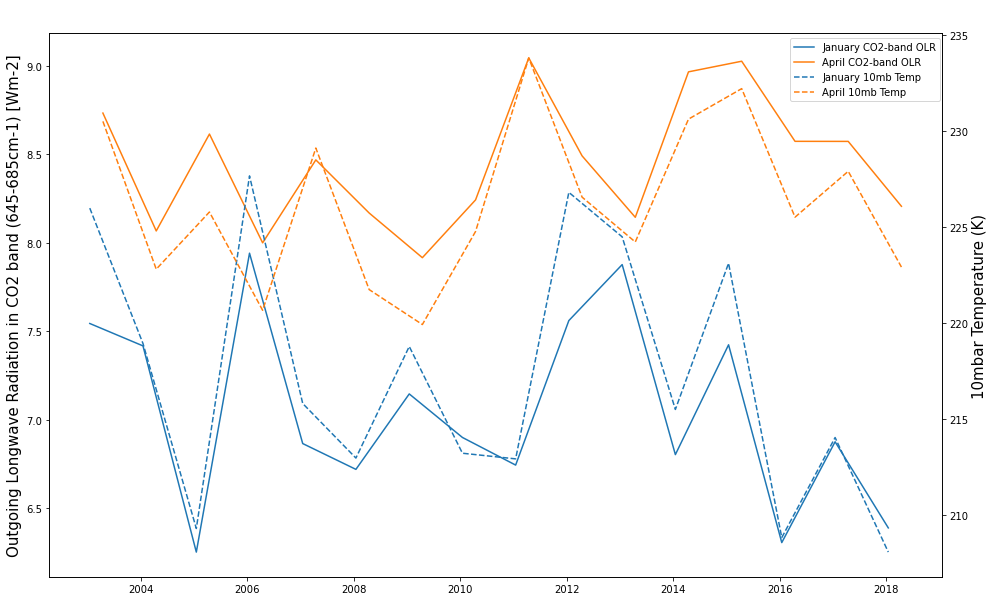

In [226]:
fig,axs = plt.subplots(1,1,figsize=(16,10))

axs0b = plt.twinx(axs)
axs.set_ylabel('Outgoing Longwave Radiation in CO2 band (645-685cm-1) [Wm-2]',fontsize=15)
axs0b.set_ylabel('10mbar Temperature (K)',fontsize=15)

jan_olr_line = axs.plot(olr_CO2_jan['time'],olr_CO2_jan,label='January CO2-band OLR')
apr_olr_line = axs.plot(olr_CO2_apr['time'],olr_CO2_apr,label='April CO2-band OLR')

jan_10mbT_line = axs0b.plot(olr_CO2_jan['time'],airs_10mbar_temp_arcmean_jan,label='January 10mb Temp',linestyle='dashed') # using the other time values to avoid an error
apr_10mbT_line = axs0b.plot(olr_CO2_apr['time'],airs_10mbar_temp_arcmean_apr,label='April 10mb Temp',linestyle='dashed')

handles = [jan_olr_line,apr_olr_line,jan_10mbT_line,apr_10mbT_line]

fig.legend((jan_olr_line,apr_olr_line,jan_10mbT_line,apr_10mbT_line),
           labels=('January CO2-band OLR','April CO2-band OLR','January 10mb Temp','April 10mb Temp'),
           loc=[0.795,0.83],
          )

$$ t = \frac{r \sqrt{N-2}}{\sqrt{1-r^2}} $$

In [159]:
_slope_jan,_intercept_jan,_rvalue_jan,_pvalue_jan,_sterr_jan = stats.linregress(olr_CO2_jan['time.year'],olr_CO2_jan)
_slope_apr,_intercept_apr,_rvalue_apr,_pvalue_apr,_sterr_apr = stats.linregress(olr_CO2_apr['time.year'],olr_CO2_apr)

stats.linregress(olr_CO2_apr['time.year'],olr_CO2_apr)

# Use a student's t-test to confirm that any trends from this data are not confident in terms of the sign.
N = len(olr_CO2_jan)

t_crit = stats.t.ppf(0.975,N-2)
print('t-crit is %.2f' % t_crit)

t_jan = _rvalue_jan * np.sqrt(N - 2) / np.sqrt(1 - _rvalue_jan**2)
t_apr = _rvalue_apr * np.sqrt(N - 2) / np.sqrt(1 - _rvalue_apr**2)
print('t-statistic January: %.2f' % t_jan)
print('t-statistic April: %.2f' % t_apr)

t-crit is 2.14
t-statistic January: -1.13
t-statistic April: 0.99


In both, cases, these trends are not statistically significant, so they don't represent a change in the radiation fields. Whether they capture stratospheric temperatures is a totally different question though.

In [ ]:
Year Date Duration Tave Tmax ∆T ZM ZWmax Class Epoch
(DOY) (Days) (K) (K) (K) (m/s) (DOY)

2000 79 64.75 224 235 10 4.2 D 77.00
2000 355 13.00 223 227 8 -5.7 S 358.00
2001 41 23.50 228 232 18 14.3 S 38.00
2001 361 35.75 224 237 14 7.7 D 357.75
2002 47 20.50 229 234 13 -0.1 D/S 49.50
2003 17 77.25 223 232 10 12.9 S 66.50
2004 3 25.75 227 232 18 11.8 S 4.00
2005 70 29.25 229 233 11 12.9 S 66.50
2006 20 34.50 227 236 14 24.1 S 18.50
2007 53 55.50 223 231 8 9.7 D 57.00
2008 52 54.00 225 238 14 13.9 D 57.00
2009 23 23.75 231 251 23 30.2 S 19.50
2010 26 17.25 228 235 21 7.1 S 28.00